### BigFig - generaets figures and spectra for different pitches

In [8]:
# Set parameter file and model to load
from utils.myUtils import mostRecent 

# chose an existing pickledParamFile and run loadModelForEvaluation
pickledParamFile = mostRecent("demoModel/*modelParams.pkl")
#pickledParamFile = mostRecent("/home/lonce/ZCODE/PYTORCH/RNNControl/model/*modelParams.pkl")
#pickledParamFile = '/home/lonce/ZCODE/PYTORCH/HUZ/RNNControl/model.WorkingTransients/modelParams.pkl'

# choose saved model to run (defaults to the last saved if loadmodelfile is undefined or None)
# Note: looks in same directory as pickledParamFile
loadModelFileName=None
#loadModelFileName='2018-11-23_09-37-53_model_epoch1_step90.pth'
#loadModelFileName='2018-10-31_16-47-25_model_epoch1_step4000.pth'

In [9]:
# run notebook to load analysis/synthesis code
%run loadModelForEvaluation.ipynb

if 'sample_rate' not in params :   #older versions didn't save sample_rate
    params['sample_rate']=16000

python version 3.6.6
torch version 0.4.1
will read params from /home/lonce/ZCODE/PYTORCH/HUZ/RNNControl/model.WorkingTransients/modelParams.pkl
modelDir is /home/lonce/ZCODE/PYTORCH/HUZ/RNNControl/model.WorkingTransients

 Saved Parameters:

{'batch_size': 256,
 'datadir': '/tmp/synth.64.76.ConstSlopeTransients_Even.1.len.6.1.0_Odd.01.len.6.2.0',
 'hiNote': 76,
 'hiddenSize': 50,
 'lowNote': 64,
 'lr': 0.005,
 'max_steps': 8000,
 'nLayers': 4,
 'noise': 0.1,
 'num_epochs': 1,
 'paramdir': '/tmp/synth.64.76.ConstSlopeTransients_Even.1.len.6.1.0_Odd.01.len.6.2.0/dataparams',
 'props': ['instID', 'pressure1', 'midiPitch'],
 'savedModel': 'model/2018-10-31_17-46-33_model_epoch1_step8000.pth',
 'savedSteps': 8000,
 'savemodel': True,
 'savemodel_interval': 500,
 'savemodeldir': 'model',
 'seqLen': 512,
 'stride': 1}
setting loadModelFile to /home/lonce/ZCODE/PYTORCH/HUZ/RNNControl/model.WorkingTransients/2018-10-31_16-47-25_model_epoch1_step4000.pth
*****************************************

### Primer  
<a id="primer"></a>

In [10]:
# Make noisy nuetral Priming signal 
myp=np.zeros([1,seqLen,len(params['props'])+1])
# !! PRIMING DOES MATTER - has to be a certain level of noise
myp[0,:,0]=.3*np.random.ranf([seqLen])-.15 #signal
myp[0,:,1]= .45+.1*np.random.ranf([seqLen])     #instrument
myp[0,:,2]= .5*np.random.ranf([seqLen])    #pressure1
#myp[0,:,3]=1-myp[0,:,2]    #pressure2
myp[0,:,3]= np.random.ranf([seqLen])    #pitch
myprimer=torch.tensor(myp, dtype=torch.float)


In [11]:
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import FloatSlider
%matplotlib inline

# Show spectrum

def showSnr(sig, freq, octavespan=3) : #span above and below # lowfspan=100, hifspan=100) 
    
    mffts=np.absolute(np.fft.fft(sig))
    freqs= np.fft.fftfreq(len(sig), 1/sr)
    
    #Compute bin numbers for spectrogram display
    sl=len(sig)
    freqbin= int(np.round(freq*sl/sr))
    lowf=freq*np.power(2.,-octavespan)
    lowbin=int(np.round(max(0, lowf*sl/sr)))
    hif=freq*np.power(2.,octavespan)
    hibin=int(np.round(min(sl/2 ,hif*sl/sr)))
    
    print("showSNR f = " + str(freq) + ", binnumber = " + str(freqbin))
    print("showSNR lowf = " + str(lowf) + ", binnumber = " + str(lowbin))
    print("showSNR hif = " + str(hif) + ", binnumber = " + str(hibin))
    
    plt.show()
    plt.plot(freqs[lowbin:hibin], mffts[lowbin:hibin])
    #plt.plot(mffts[:1500])
    
    total = np.sum(mffts[0:int(len(mffts)/2)])
    snr_freq= mffts[freqbin]/total
    maxbin=np.argmax(mffts[0:int(len(mffts)/2)])
    snr_max=mffts[maxbin]/total
    print('center freq (' + str(freq) + "), bin " + str(freqbin)+  "=" + str(float("{0:.6f}".format(snr_freq))) + ", and at max freq  (" + str(freqs[maxbin]) + "), bin " + str(maxbin) +  "=" + str(float("{0:.6f}".format(snr_max))))
     
    #return the snr for the requested bin
    return mffts[freqbin]/total



### <font color="brown"> Generate the Big Fig, with sig and spectra at various frequencies</font>

*** Evaluate for param = 64, freq = 329.6275569128699, volume 0.75, instn 1


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f79984fc0b8>>
Traceback (most recent call last):
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/lonce/anaconda3/envs/snn/lib/python3.

*** Evaluate for param = 66, freq = 369.9944227116344, volume 0.75, instn 1
*** Evaluate for param = 68, freq = 415.3046975799451, volume 0.75, instn 1
*** Evaluate for param = 69, freq = 440.0, volume 0.75, instn 1
*** Evaluate for param = 71, freq = 493.8833012561241, volume 0.75, instn 1


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f7998204940>>
Traceback (most recent call last):
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/lonce/anaconda3/envs/snn/lib/python3.6/multiprocessing/red

*** Evaluate for param = 73, freq = 554.3652619537442, volume 0.75, instn 1
*** Evaluate for param = 75, freq = 622.2539674441617, volume 0.75, instn 1
*** Evaluate for param = 76, freq = 659.2551138257398, volume 0.75, instn 1


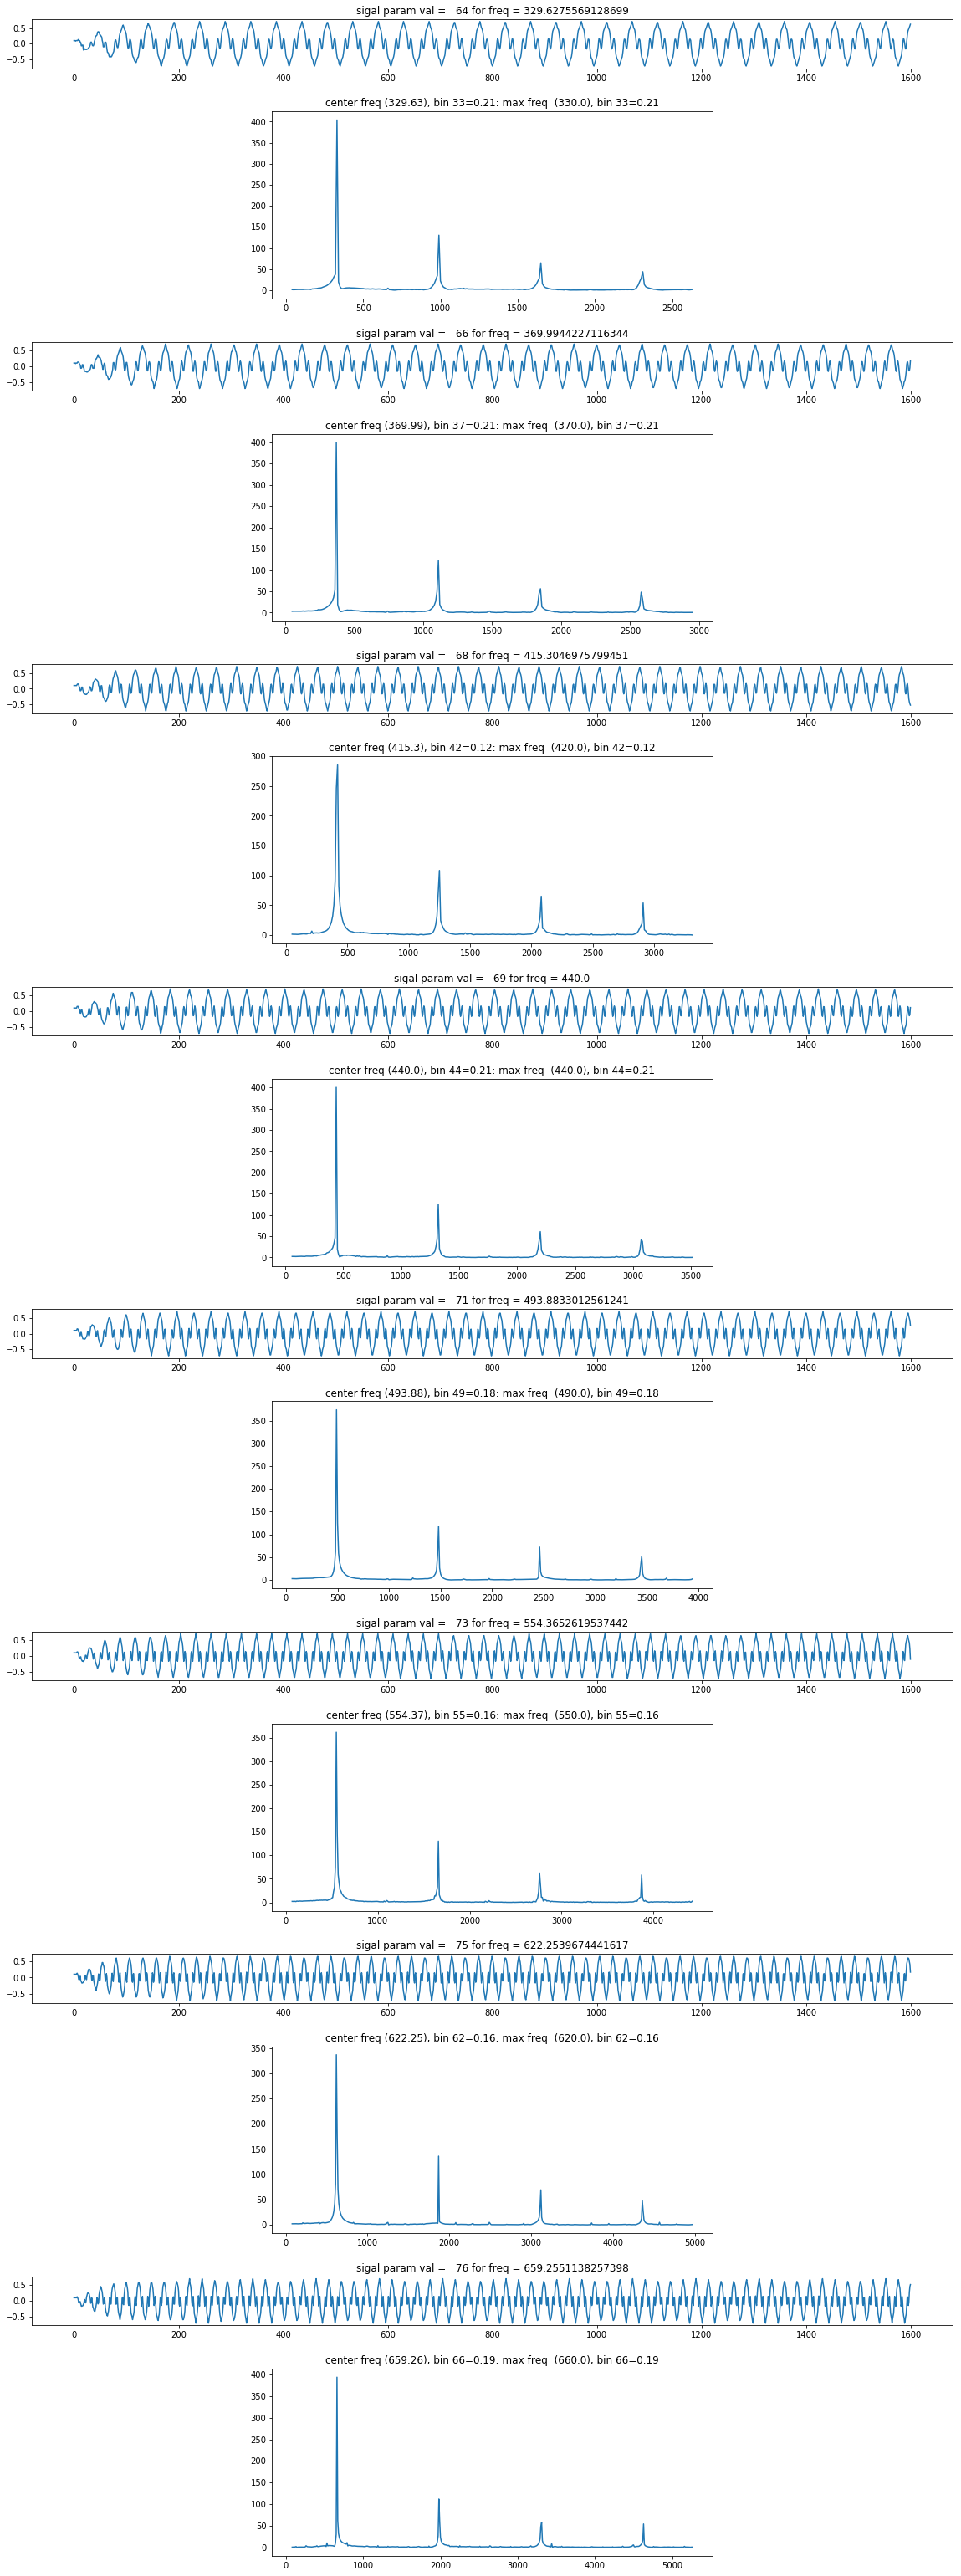

In [12]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec

beg=0   # sample numbers for plotting signal
end=1600

genlen=int(sr/10)

octavespan=3 #width to display on spectrogram around center frequency


gvals = np.array([0, 2,4,5,7,9,11,12])+params['lowNote']
#pvals = [0, .5, 1]
#gvals = np.array([5])+params['lowNote']
a=[None]*2*len(gvals) #list for holding subplots (for possible individual access later)
sigrspan=2
sigcspan=4
spectrspan=5
spectcspan=2

pairrows = sigrspan+spectrspan

numPlotPairs=len(gvals)
gridrows = numPlotPairs*(spectrspan+sigrspan+2)
gridcols=6

fig = plt.figure(figsize=(5*gridcols, gridrows))  #(width, height) in inches (say the docs)!
fig.subplots_adjust(hspace=15)

gridspec.GridSpec(gridrows,gridcols)

vol=.75
instn=1

i=0
j=0
for gval in gvals :
    freq = midi.param2freq(gval)
    normedf=midi.param2norm(gval)
    
    print("*** Evaluate for param = " + str(gval) + ", freq = " + str(freq) + ", volume " + \
          str(vol) + ", instn " + str(instn))
    #sig=evaluate(genlen, lambda n: [normedf, vol, instn], temperature=chooseTemperature,\
                 #primeWith=k_primeSignal,verbose=False)[:, 0]#[k_primeLen:, 0]
    
    sig=generate(rnn, genlen, primer=myprimer, paramvect=lambda n: [instn, vol, normedf ])[seqLen:]

    #save wave file
    outfilename=k_rootoutname +"/bigfig_snd." + str(gval)
    librosa.output.write_wav(outfilename +".wav", sig, sr)
    
    #plot signal tempRunOutDir
    rowspan=2
    colspan=2
    a[i]=plt.subplot2grid((gridrows,gridcols), (j*pairrows,0), colspan=sigcspan, rowspan=sigrspan)
    a[i].plot(sig[beg:end])
    a[i].set_title('sigal param val =   ' + str(gval) + " for freq = " + str(freq))
    
    #save waveform image
    outfilename=outfilename+"_temporal"
    extent = a[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(outfilename + ".png", bbox_inches=extent.padded(.4))
    
 
    
    #plot transform
    rowspan=3
    colspan=1
    
    mffts=np.absolute(np.fft.fft(sig))
    freqs= np.fft.fftfreq(len(sig), 1/sr)   # for labeling spectrum x-axis
    
    #Compute bin numbers for spectrogram display
    sl=len(sig)
    freqbin= int(np.round(freq*sl/sr))
    lowf=freq*np.power(2.,-octavespan)
    lowbin=int(np.round(max(0, lowf*sl/sr)))
    hif=freq*np.power(2.,octavespan)
    hibin=int(np.round(min(sl/2 ,hif*sl/sr)))
        
     
    total = np.sum(mffts[0:int(len(mffts)/2)])
    snr_freq= mffts[freqbin]/total
    maxbin=np.argmax(mffts[0:int(len(mffts)/2)])
    snr_max=mffts[maxbin]/total
           
    i=i+1
    a[i]=plt.subplot2grid((gridrows,gridcols), (j*pairrows+sigrspan,1), colspan=spectcspan, rowspan=spectrspan)
    a[i].plot(freqs[lowbin:hibin], mffts[lowbin:hibin])
    a[i].set_title('center freq (' + str(float("{0:.2f}".format(freq))) + \
                   "), bin " + str(freqbin)+  "=" + str(float("{0:.2f}".format(snr_freq))) + \
                   ": max freq  (" + str(float("{0:.2f}".format(freqs[maxbin]))) + \
                   "), bin " + str(maxbin) +  "=" + str(float("{0:.2f}".format(snr_max))))
    
    #save spectral image
    outfilename=outfilename+"_spectral"
    extent = a[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(outfilename + ".png", bbox_inches=extent.padded(.4))

    
    
    i=i+1
    j=j+1

#save the BIG FIG
plt.savefig(k_rootoutname + "/BIGFIG" ".png")

In [13]:
from IPython.display import Audio, display
#Wanna hear any of those?
normedf=9+params['lowNote']
wavfilename=  k_rootoutname +"/bigfig_snd." + str(normedf)+".wav"
print(wavfilename)

x, sr = librosa.load(wavfilename, sr=None)
display(Audio(x, rate=16000, autoplay=True))

./output/bigfig_snd.73.wav


In [14]:
# Save the "sub figures" individually, too. They are numbered in the order they are created, and the 
# labels are already on figures. Even numbered are wavs, odd numbered are spectral
for saveidx in range(2*len(gvals)) : #run this cell?
    #saveidx=1
    outfilename=k_rootoutname+"/subfig" + str(saveidx)+".png"
    #print("saving to file " + outfilename)
    extent = a[saveidx].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #print(extent)
    fig.savefig(outfilename, bbox_inches=extent.padded(.4))

print("saved subfigs to dir " + k_rootoutname)
#https://matplotlib.org/api/transformations.html#matplotlib.transforms.Bbox

saved subfigs to dir ./output
